# AIN429 Project : Credit Card Fraud Detection

**Due Date:** 17.01.2023

---------------------------------------

**TA:** Ahmet ALKILINÇ

---------------------------------------
**Student Name Surname**: Melike Nur Dulkadir
**Student ID**: 21992919

In this project, the following steps will be applied:
-Data Collection
-Data Preprocessing and Cleaning
-Data Exploration
-Feature Engineering
-Predictive Modelling
-Data Visualization

Before starting the project necessary libraries are imported.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from matplotlib import gridspec


# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier



# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, plot_precision_recall_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings("ignore")

###  1- Data Collection

In this step, we will choose an existing dataset and follow the above steps one by one. Before, it is requested to get the subsample of the selected dataset.

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. In this dataset, there are pre-transformed transaction data, time and amount values as features. As a result, there is a label according to whether the relevant example is fraud or non fraud. This information is also included in the class column.

- Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. We also know that the full meaning of these features is not given in terms of privacy.

- Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.

- Feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning.

You can access the dataset from this link : [Dataset link](https://www.kaggle.com/mlg-ulb/creditcardfraud)

In [14]:
df = pd.read_csv("creditcard.csv")

In [15]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


check_df function is a util function that allows us to examine the dataset in general.

In [16]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print("##################### Properties #####################")
    print(df.describe())

grab_col_name function is a util function that allows us to determine categorical, numerical and cardinal columns.

In [17]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                Class threshold for numeric but categorical variables
        car_th: int, optinal
                Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat inside cat_cols.
        The sum of the 3 returned lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    return cat_cols, num_cols, cat_but_car

The following functions are util functions created to be used during model evaluation.

In [18]:
def display_confusion_matrix(confusion_matrix):
    # Heatmap display for confusion matrix
    labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
    length = len(max(labels)) + 10
    labels = np.asarray(labels).reshape(2, 2)

    annots = [f"{str(label)}({str(value)})" for array in np.dstack((labels, confusion_matrix)) for (label, value) in
              array]
    annots = np.asarray(annots).reshape(2, 2).astype(str)
    plt.figure(figsize=(7, 7))
    plt.title("Confusion Matrix of LogReg")
    sns.heatmap(confusion_matrix, annot=annots, fmt=f".{length}")
    plt.show()

In [19]:
def print_metric(y_test, predictions):
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    _confusion_matrix = confusion_matrix(y_test, predictions)
    display_confusion_matrix(_confusion_matrix)
    print(f"Precision: {precision}, Recall: {recall}, F1: {f1}, Accuracy: {accuracy}")

The following 4 different functions are utils functions created to analyze and handle outliers.

In [20]:
# Defining thresholds for outlier detection
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [21]:
# Checks if there is an outlier in the dataset
def check_outlier(dataframe, col_name, q1=.05, q3=.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [22]:
# Change outlier values with thresholds
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [23]:
# Showing the outlier values
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [24]:
check_df(df)

##################### Shape #####################
(284807, 31)
##################### Types #####################
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object
##################### NA #####################
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22 

The dataset contains 284807 different observations and 30 different features. In addition, the last column in the dataset contains the output class. All features except Output are in float type. We can also observe the quantile values and properties of the dataset that does not contain any missing values.

In [25]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 284807
Variables: 31
cat_cols: 0
num_cols: 31
cat_but_car: 0


Dataset only contains numerical columns.

### 2-Data Preprocessing and Cleaning

In this step, I will apply preprocess operations such as scaling and cleaning in order to remove the noises in the selected dataset.

In [26]:
for col in num_cols:
    print(check_outlier(df,col))

False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Except for the first column, each column has an outlier value. However, the outlier values in this dataset may be data belonging to the fraud class, which is found in a very small amount. Due to confidentiality, we do not know what the columns represent, so it may not be correct to process outlier values at this stage.

In [27]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

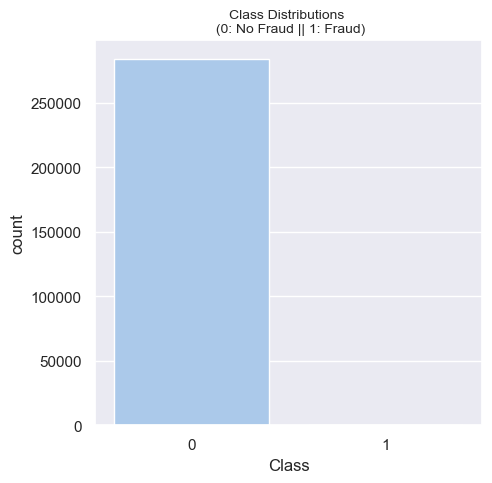

In [28]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x='Class', data=df, palette='pastel6')
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=10)

As can be observed from the image created with the help of countplot. The dataset is highly unbalanced.

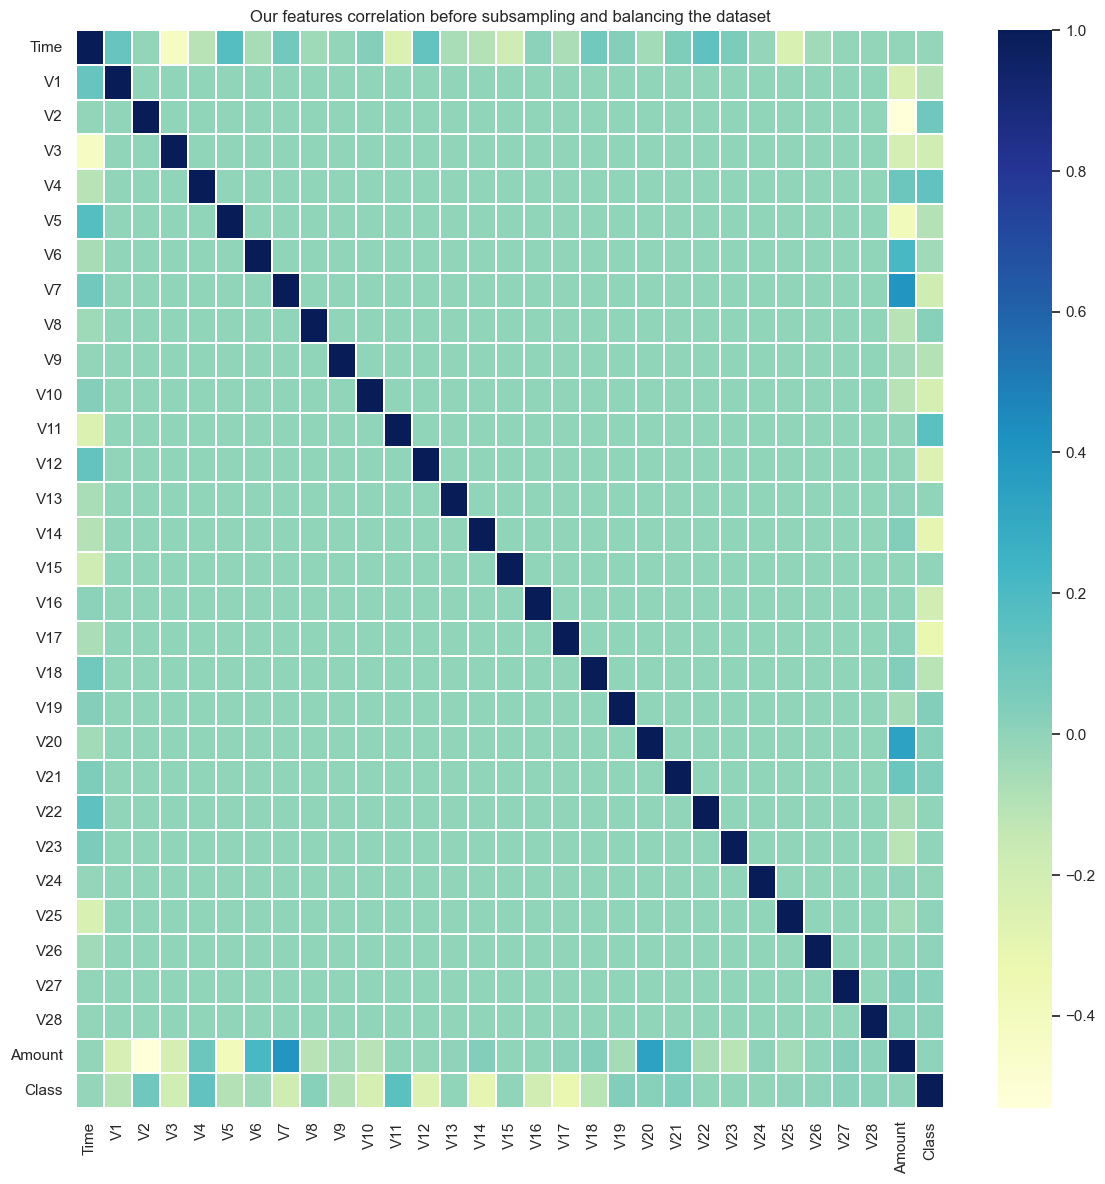

In [29]:
plt.figure(figsize = (14,14))
plt.title("Our features correlation before subsampling and balancing the dataset")
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="YlGnBu")
plt.show()

It is necessary to use a correlation map to see if some features in our dataset directly and seriously affect the class result.

Since this correlation table contains data before subsampling, it is not correct to comment. Because our correlation matrix will be affected by high imbalance. We will make a more accurate interpretation after balancing.

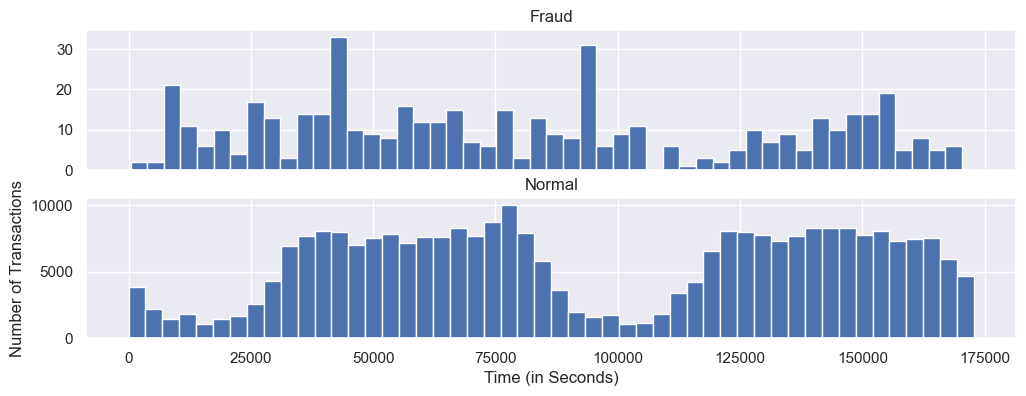

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex= 'all', figsize=(12,4))

bins = 50

ax1.hist(df.Time[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

The 'Time' feature looks pretty similar across both types of transactions. We could argue that fraudulent transactions are more uniformly distributed, while normal transactions have a cyclical distribution. This could make it easier to detect a fraudulent transaction during at an 'off-peak' time.

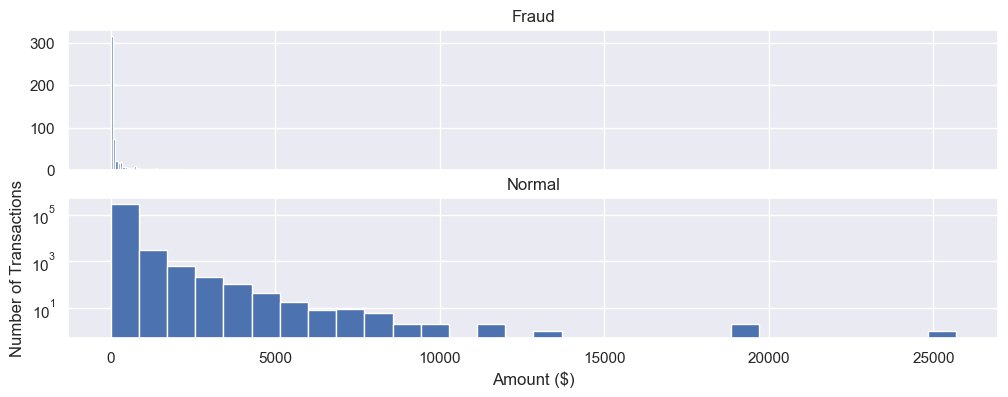

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex='all', figsize=(12,4))

bins = 30

ax1.hist(df.Amount[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

Most transactions are small amounts.

**Comparing Time with Amount**

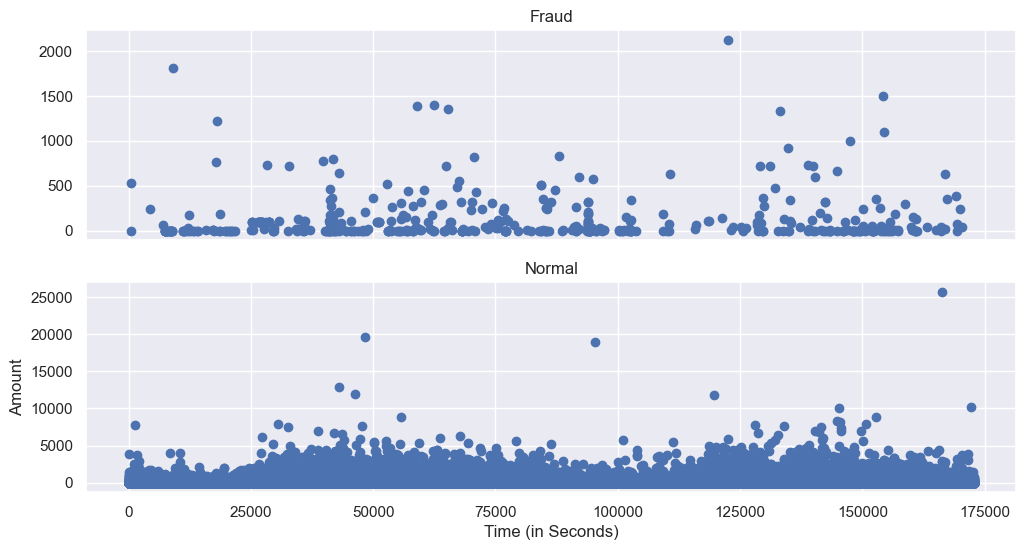

In [20]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex='all', figsize=(12,6))

ax1.scatter(df.Time[df.Class == 1], df.Amount[df.Class == 1])
ax1.set_title('Fraud')

ax2.scatter(df.Time[df.Class == 0], df.Amount[df.Class == 0])
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [21]:
v_features = df.iloc[:,1:29].columns

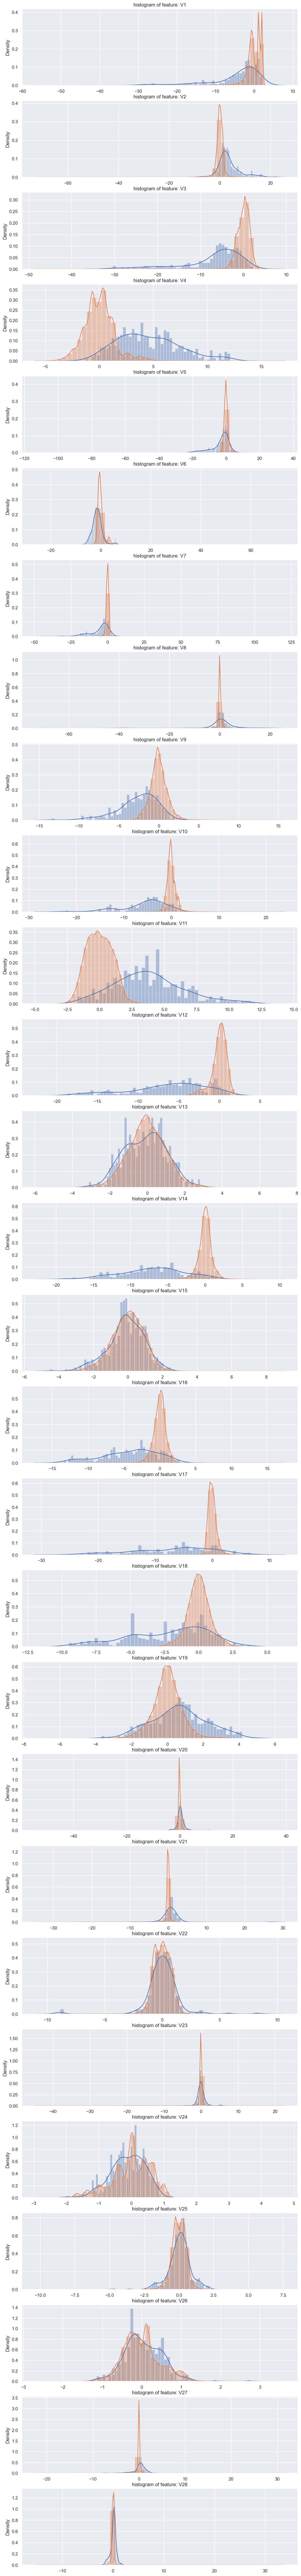

In [22]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

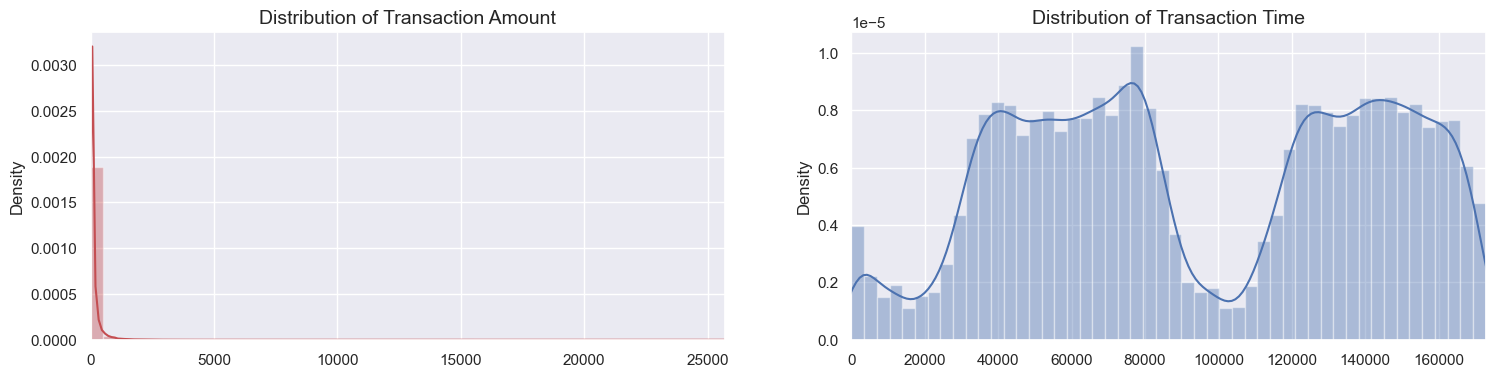

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

Since the range of values of raw data varies widely, in some machine learning algorithms, objective functions do not work correctly without normalization(scaling). So that, we will scale some of our features. Robust scaler will be used . It scales features using statistics that are robust to outliers. This scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [30]:
robust_scaler = RobustScaler()
df["scaled_time"] = robust_scaler.fit_transform(df["Time"].values.reshape(-1, 1))
df["scaled_amount"] = robust_scaler.fit_transform(df["Amount"].values.reshape(-1, 1))

df.drop(["Time","Amount"], axis=1, inplace=True)

scaled_amount = df["scaled_amount"]
scaled_time = df["scaled_time"]

df.drop(["scaled_amount","scaled_time"], axis=1, inplace=True)
df.insert(0, "scaled_amount", scaled_amount)
df.insert(1, "scaled_time", scaled_time)

# Our scaled features (time, amount) look like this.
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [31]:
#Thanks to the resample function in this helper class, we will be able to resampling in the pipeline. We will see the differences according to whether this process is done before and during the CV in the predictive modeling section.

class RandomUnderSamplerHelper(BaseEstimator):

    def __init__(self,random_state=None):
        self.random_state = random_state

    def fit_resample(self, X, y):
        return self.resample(X, y) # Pipeline calls this function.

    def resample(self, X, y):
        df = pd.concat([X, y], axis=1)

        df = df.sample(frac=1, random_state=self.random_state)

        # In order to provide a good training, we need to use a 50/50 sub-dataframe (NearMiss Algorithm). However, since a training+test set with at least 4000 data points is requested from us, we will make a split accordingly.
        fraud_df = df.loc[df["Class"] == 1]  # 492(all of them) fraud sample selected.
        non_fraud_df = df.loc[df["Class"] == 0][:3508] # 3508 non-fraud sample selected.

        # Concatenating dataframes.
        distributed_df = pd.concat([fraud_df, non_fraud_df])

        # Shuffling dataframe rows.
        new_df = distributed_df.sample(frac=1, random_state=1)

        X = new_df.loc[:,new_df.columns != "Class"]
        y = new_df.loc[:,["Class"]]

        return X, y

### 3- Feature Engineering, Data Exploration and Analysis

#### Undersampling

<center><img src="https://dataaspirant.com/wp-content/uploads/2020/08/17-undersampling.png" title="Data Science Life Cycle" width="650"/></center>

Undersampling refers to a group of techniques designed to balance the class distribution for a classification dataset that has a skewed class distribution.

An imbalanced class distribution will have one or more classes with few examples (the minority classes) and one or more classes with many examples (the majority classes). It is best understood in the context of a binary (two-class) classification problem where class 0 is the majority class and class 1 is the minority class.

Undersampling techniques remove examples from the training dataset that belong to the majority class in order to better balance the class distribution, such as reducing the skew from a 1:100 to a 1:10, 1:2, or even a 1:1 class distribution. This is different from oversampling that involves adding examples to the minority class in an effort to reduce the skew in the class distribution.

Random Under-Sampling can be predicted to produce an undesirable result. Because when applying this technique, we choose a small majority class subsample from a very large majority class dataset, so the loss of information will be high.

If we trained our model with imbalanced data, false accuracy would be given as there would be a high bias to non fraud samples.

Situations that may occur as a result of training with Imbalanced data:

- Overfitting: Our model would predict most instances as non fraud due to instability in the training set. However, we want a precise result in the prediction of cases with fraud and we will measure this with other accuracy metrics. (We want to detect patterns of sign that given sample is fraud, not to assume.)

- Correlation errors: It is important to use balanced data to see the effect of V features on the label result.

So that, we did under-sampling. (Over-sampling (SMOTE) could be also done, but we want less data.)

Distribution of the classes in the subsample dataset
0    0.877
1    0.123
Name: Class, dtype: float64


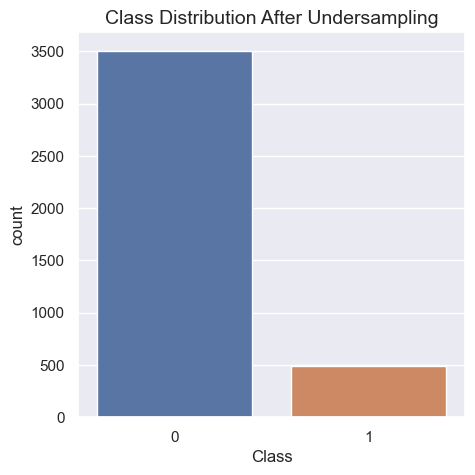

In [32]:
# As you can see, the distribution of classes in our data now have slightly better balance.
random_sampler = RandomUnderSamplerHelper()
newDf_X = df.loc[:,df.columns != 'Class']
newDf_y = df.loc[:,['Class']]

random_sampled_x, random_sampled_y = random_sampler.fit_resample(newDf_X,newDf_y)
df1 = pd.DataFrame(random_sampled_x)
df2 = pd.DataFrame(random_sampled_y)
new_df = pd.concat([df1,df2], axis=1)

print("Distribution of the classes in the subsample dataset")
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot(x ="Class", data=new_df)
plt.title("Class Distribution After Undersampling", fontsize=14)
plt.show()

In [33]:
non_fraud = new_df[new_df["Class"] == 0]
fraud = new_df[new_df["Class"] == 1]

# Shape of our dataframe elements.
data = {"Class": ["Non-Fraud","Fraud"], "Shape": [non_fraud.shape,fraud.shape]}
info_df = pd.DataFrame(data)
info_df

,Class,Shape
0,Non-Fraud,"(3508, 31)"
1,Fraud,"(492, 31)"


In [34]:
# Dataframe's new shape.
new_df.shape

(4000, 31)

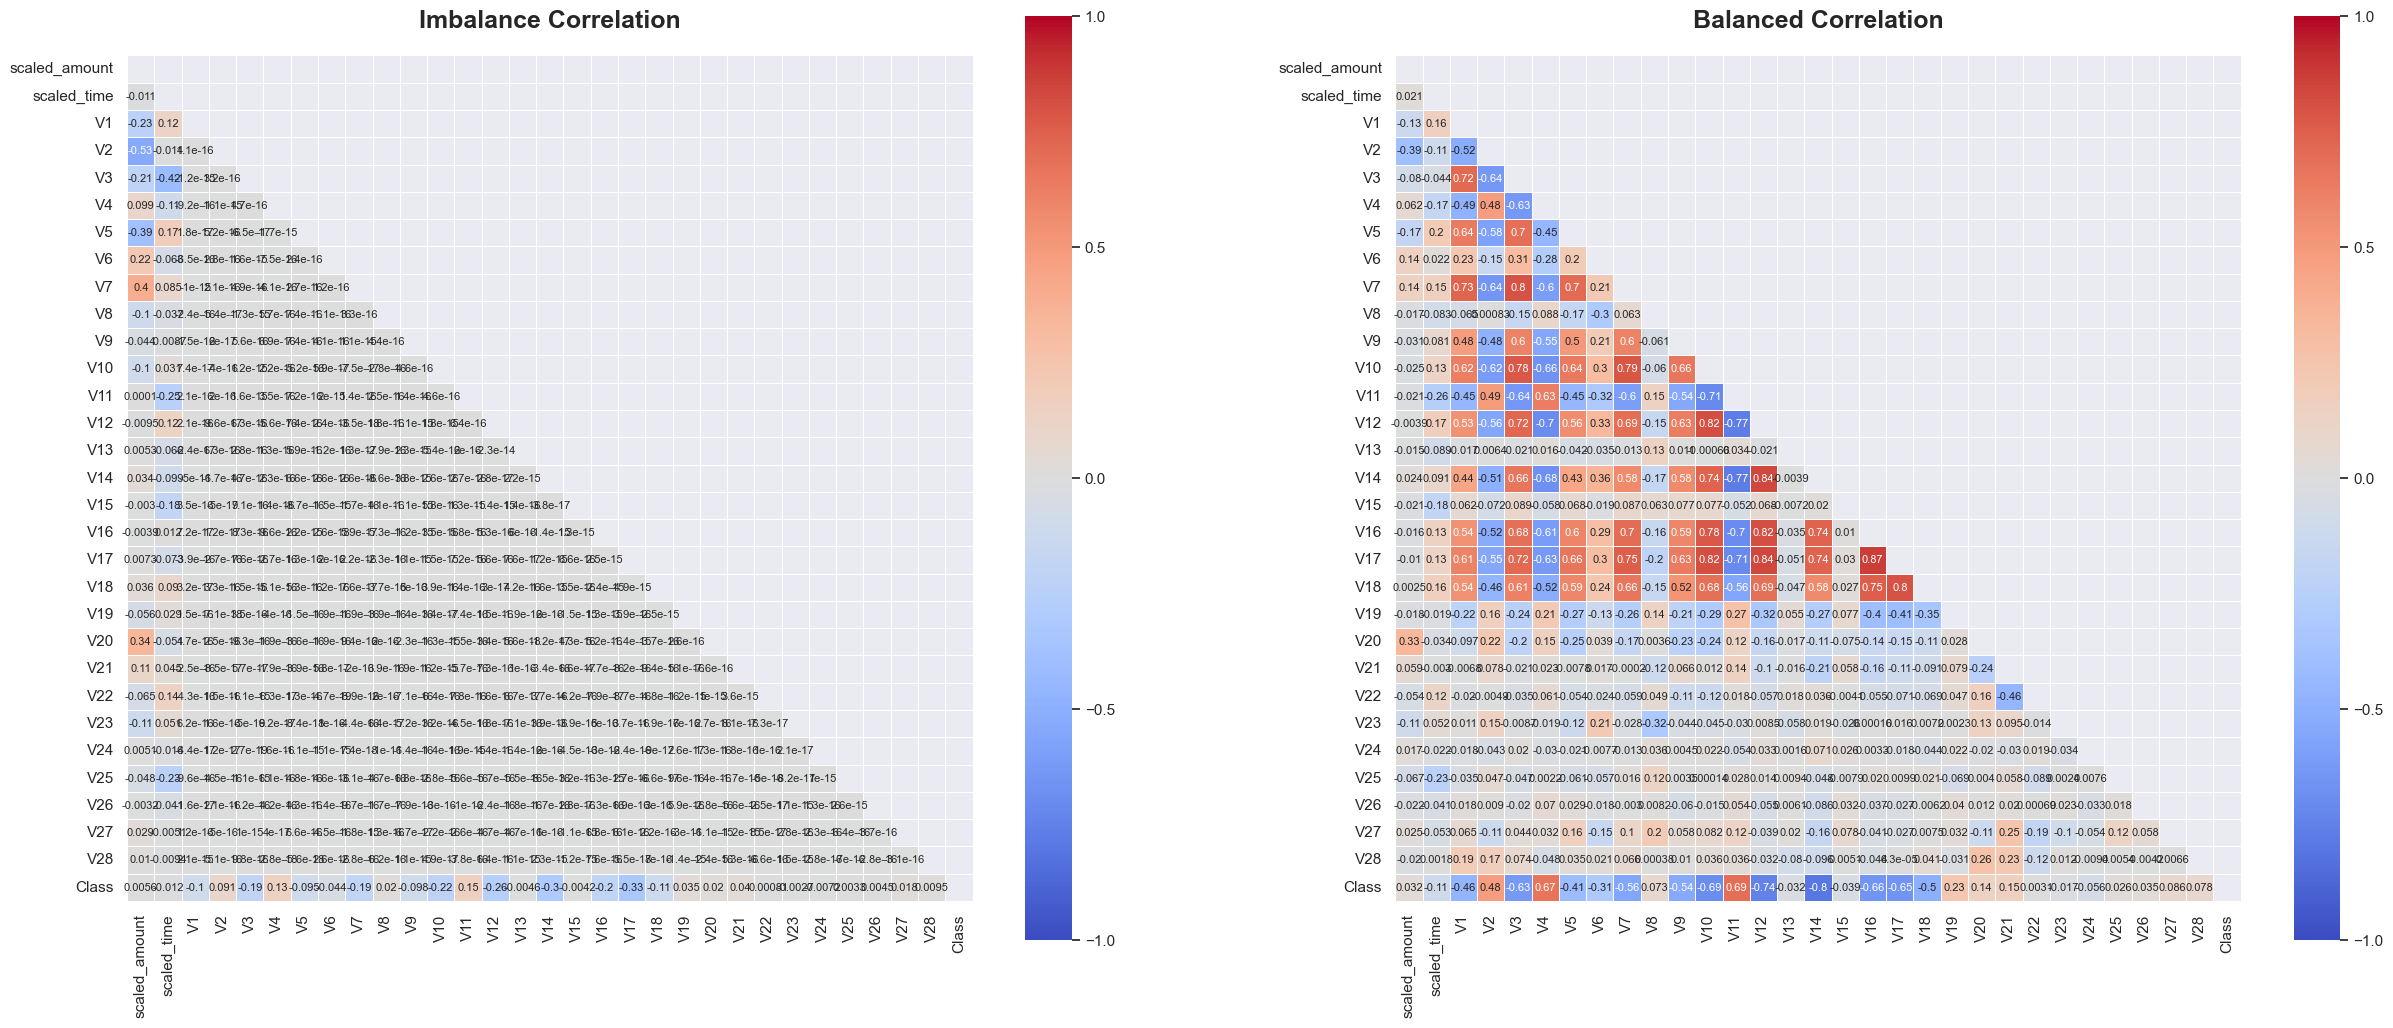

In [35]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True


f, axes = plt.subplots(ncols=2, figsize=(30,30))

heatmap = sns.heatmap(df.corr(),
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,"ticks" : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 8},
                      ax = axes[0])

axes[0].set_title('Imbalance Correlation', size = 18, weight='bold', pad=20)

heatmap = sns.heatmap(new_df.corr(),
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,"ticks" : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 8},
                      ax = axes[1])

axes[1].set_title('Balanced Correlation', size = 18, weight='bold', pad=20);

- Positively Correlated: V2, V4, V11,and V19 are positively correlated with class.
- Negetively Correlated: V3, V7, V10, V12, V14, V17 are negatively correlated with class.

We can also observe positively and negatively correlated columns with the help of boxplots.

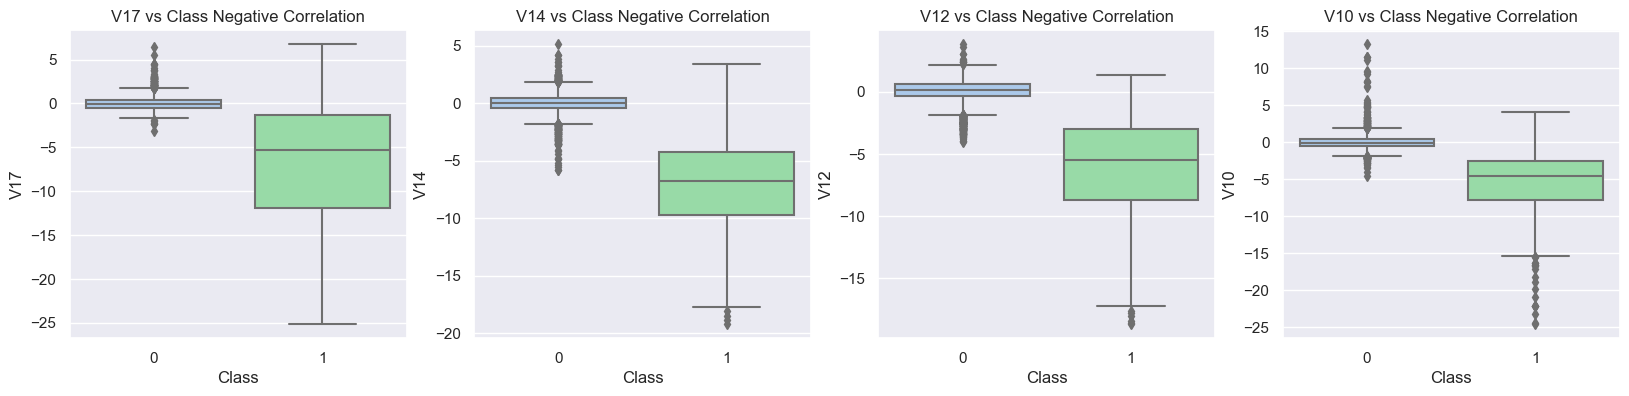

In [30]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette='pastel6', ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette='pastel6', ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette='pastel6', ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette='pastel6', ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

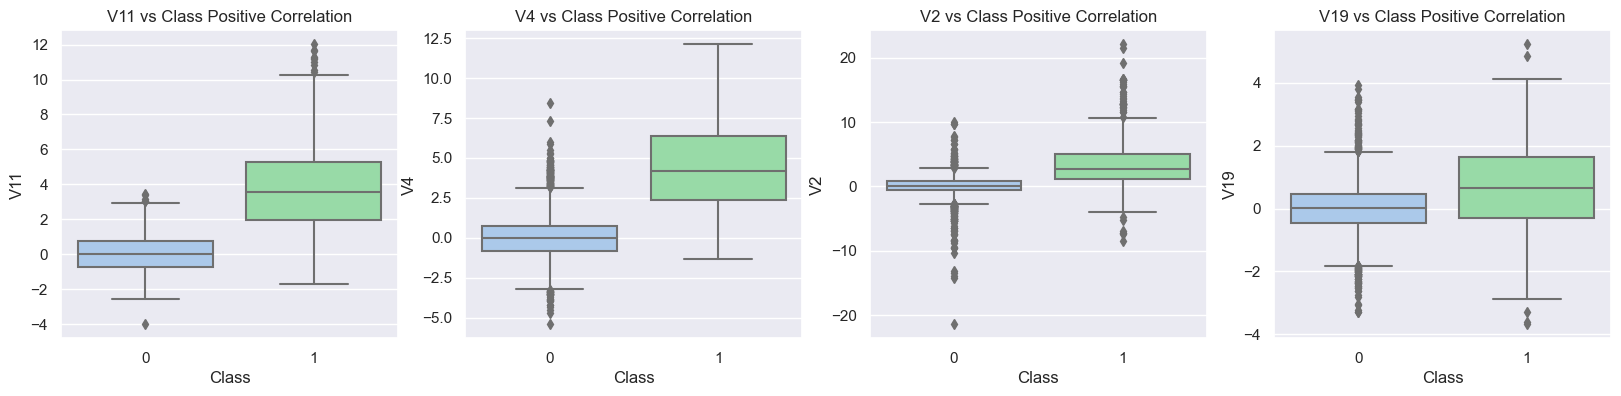

In [31]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette='pastel6', ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette='pastel6', ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette='pastel6', ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette='pastel6', ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

#### Analysis with Clustering

In [37]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [33]:
reduced_X_tSNE = TSNE(n_components=2, random_state=0).fit_transform(X.values)

The t-SNE algorithm can cluster the samples with very good accuracy, depending on whether they are fraudulent or non fraudulent.

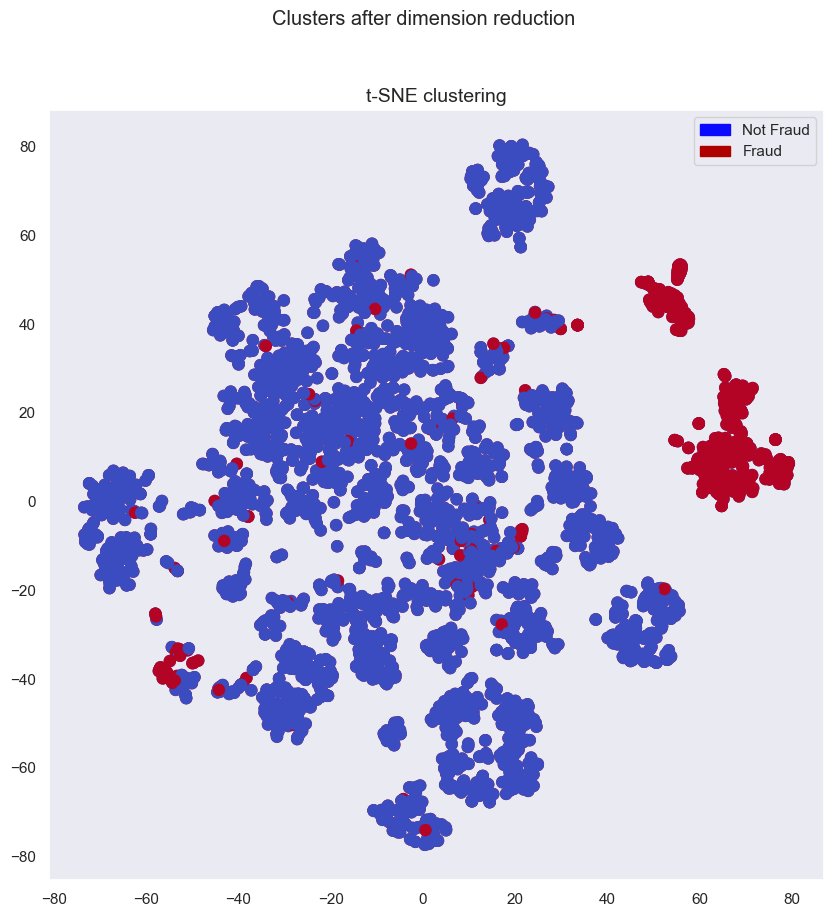

In [34]:
# Visualization after dimension reduction algorithm
f, (ax1) = plt.subplots(1, 1, figsize=(10,10))
f.suptitle("Clusters after dimension reduction")

#t-SNE scatter plot
ax1.scatter(reduced_X_tSNE[:,0], reduced_X_tSNE[:,1], c=(y == 0), cmap="coolwarm", label="No Fraud", linewidths=3)
ax1.scatter(reduced_X_tSNE[:,0], reduced_X_tSNE[:,1], c=(y == 1), cmap="coolwarm", label="Fraud", linewidths=3)
ax1.set_title("t-SNE clustering", fontsize=14)
ax1.grid(False)

blue_legend = mpatches.Patch(color="#0A0AFF", label="Not Fraud")
red_legend = mpatches.Patch(color="#AF0000", label = "Fraud")
ax1.legend(handles=[blue_legend, red_legend])
plt.show()

The t-SNE algorithm can cluster the samples with very good accuracy, depending on whether they are fraudulent or non fraudulent. This algorithm is used to visualize high-dimensional data by making it low-dimensional without much data loss.

This image can allow us to make an inference about whether predictive models can work properly on our dataset.

### 4- Predictive Modelling and Model Evaluation

In this step, we will use logistic regression to classify a sample as fraud or non fraud. We could choose the best one by considering the performance of other classifiers and regressors, but it is more important here that our code works fast and that a reliable predictor is created.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [39]:
# Let's implement simple classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(),
    "K-Nearest Neighbours": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [40]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", key, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 98.0 % accuracy score
Classifiers:  K-Nearest Neighbours Has a training score of 98.0 % accuracy score
Classifiers:  Support Vector Classifier Has a training score of 98.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 96.0 % accuracy score


#### GridSearch CV for choosing the best params

In [38]:
# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)


# We automatically get the logistic regression with the best parameters.
logistic_regression_model = grid_log_reg.best_estimator_

knn_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params)
grid_knn.fit(X_train, y_train)

# KNears best estimator
knears_neighbors = grid_knn.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
               "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

Accuracy scores of new models created with the best coins obtained after GridSearchCV was applied increased in this way.

In [39]:
log_reg_score = cross_val_score(logistic_regression_model, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knn_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knn_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  98.12%
Knears Neighbors Cross Validation Score 98.16%
Support Vector Classifier Cross Validation Score 98.03%
DecisionTree Classifier Cross Validation Score 98.16%


The plot_learning_curve function can be used to observe the changes of cross validation vs train score values.

In [40]:
# Let's Plot LogisticRegression Learning Curve
def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey='all')
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

    # Second Estimator
    train_sizes, train_scores, test_scores = learning_curve(estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",label="Cross-validation score")
    ax2.set_title("K-Nearest Neighbours Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")

    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")

    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

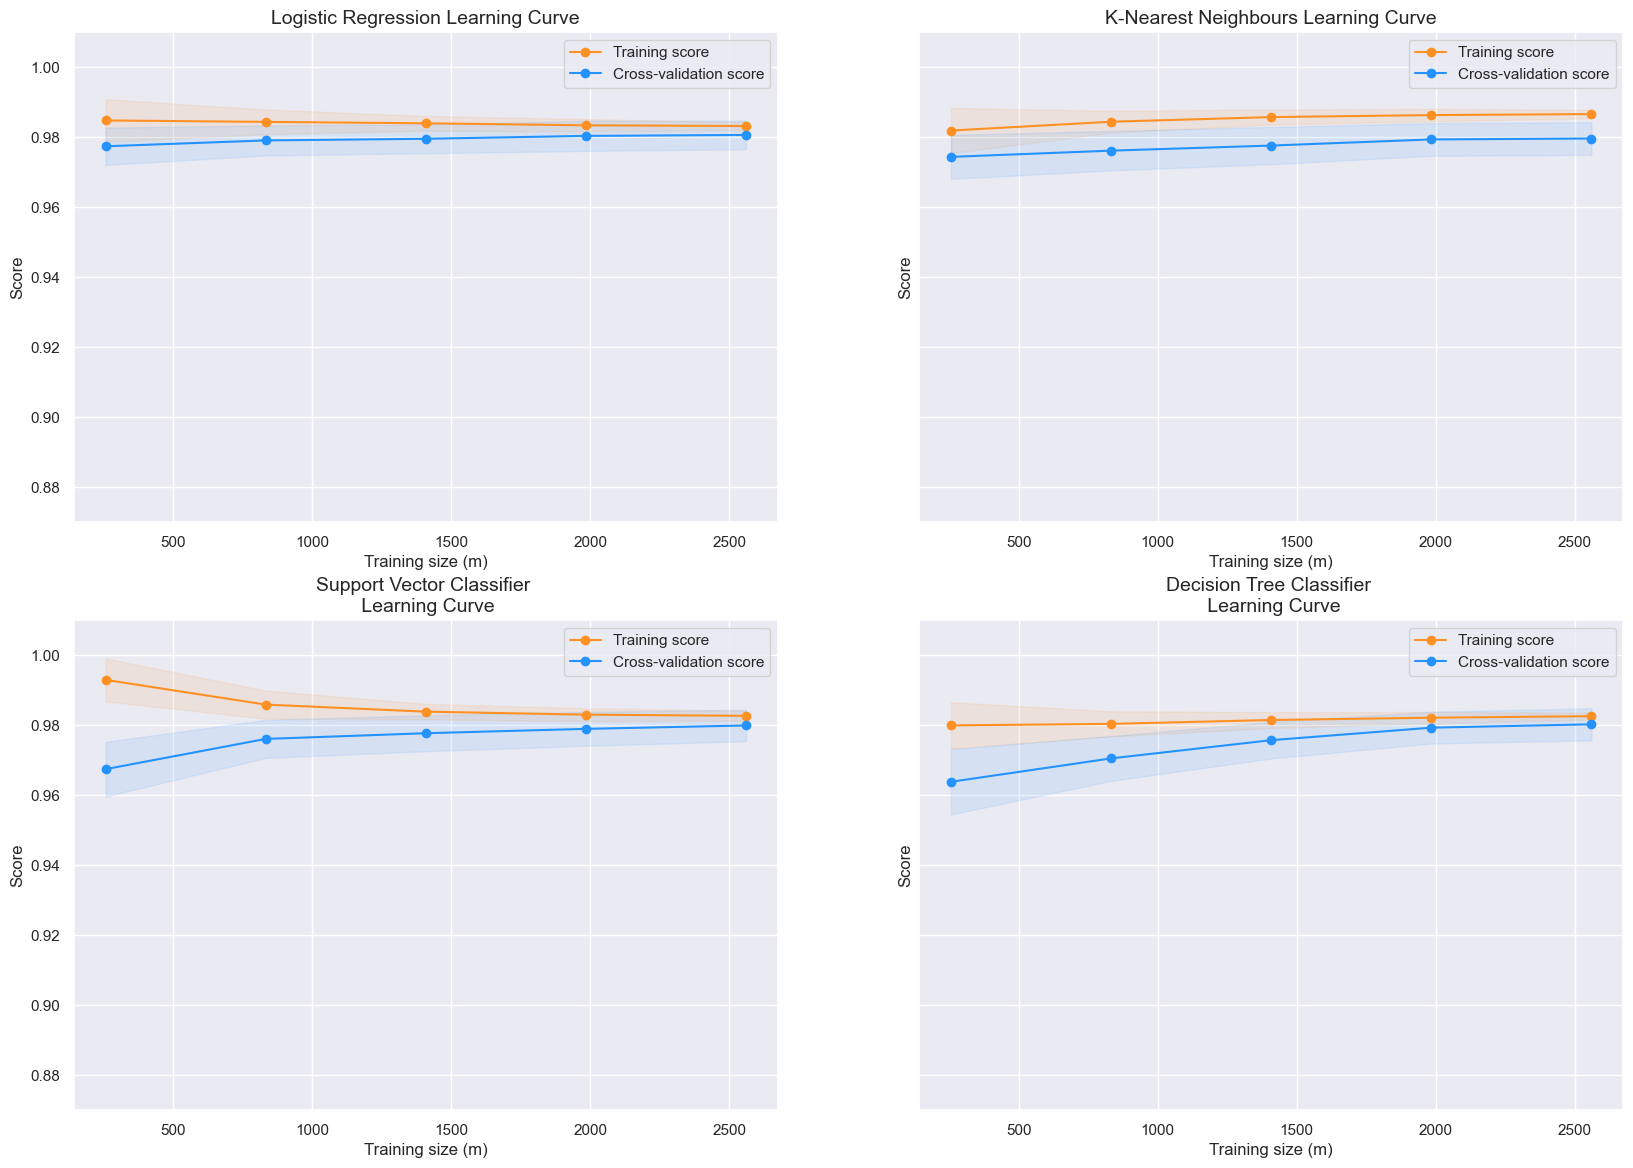

In [41]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(logistic_regression_model, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)
plt.show()

Showing all AUC scores and the classifiers names.

In [42]:
log_reg_pred = cross_val_predict(logistic_regression_model, X_train, y_train, cv=5, method="decision_function")
knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")
tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [43]:
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('K-Nearest Neighbours: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9799523139320745
K-Nearest Neighbours:  0.9305811332496355
Support Vector Classifier:  0.9735845233744947
Decision Tree Classifier:  0.930937512437091


Showing the roc curve's of all classifiers and comparing.

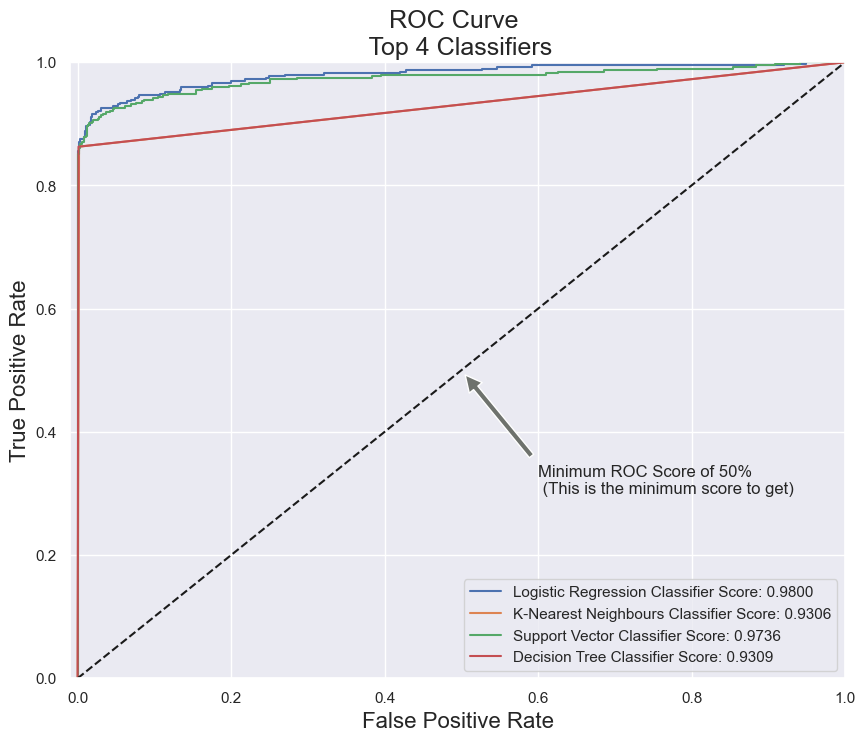

In [44]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(10,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='K-Nearest Neighbours Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                 )
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

It is seen that the Logistic Regression model, which has the best value when comparing Accuracy scores and AUC scores, is close to the line called the perfect solution in ROC curves.

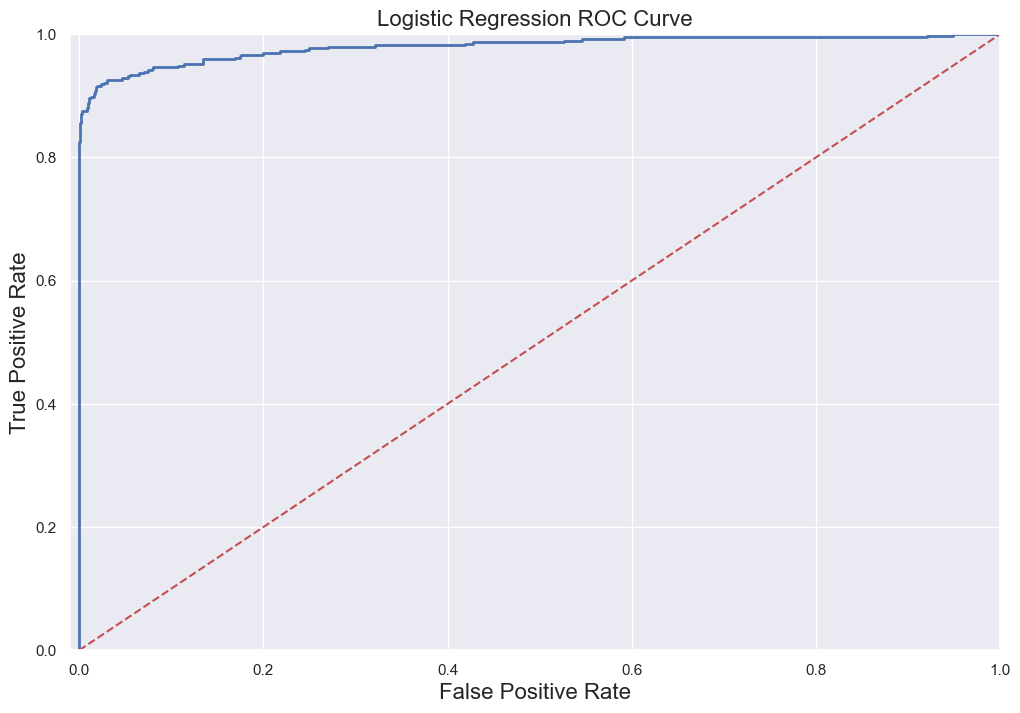

In [45]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])


logistic_roc_curve(log_fpr, log_tpr)
plt.show()

When re-visualizing the ROC curve using only the logistic regression model for a clearer visual, the model seems to work very well. Therefore, I decided to use the Logistic Regression model for the dataset.

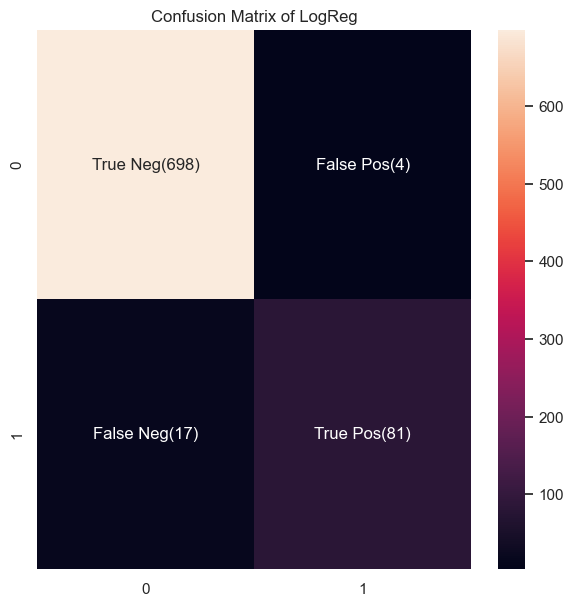

Precision: 0.9529411764705882, Recall: 0.826530612244898, F1: 0.8852459016393441, Accuracy: 0.97375


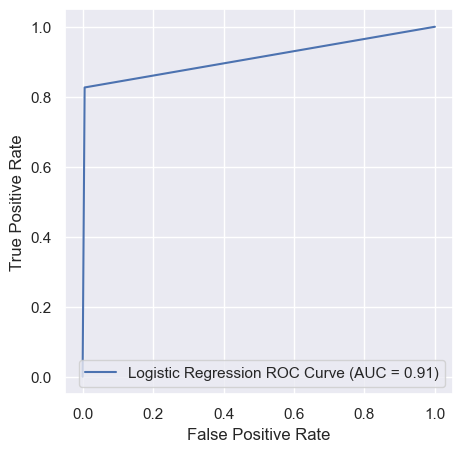

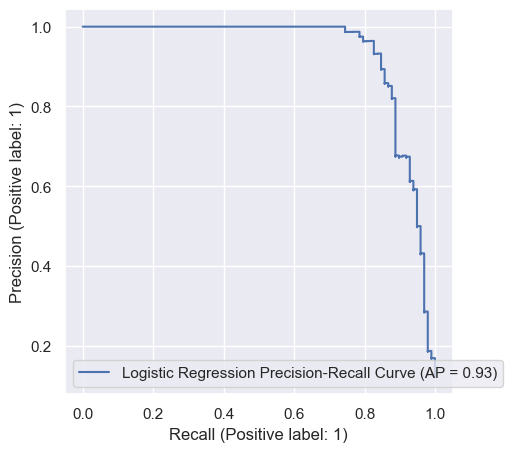

In [46]:
predictions_logreg = logistic_regression_model.predict(X_test) # Model evaluation.

print_metric(y_test,predictions_logreg) # Printing all the metric scores with test results.

fpr, tpr, thresholds = roc_curve(y_test, predictions_logreg) # Calculating Roc curve values.

roc_auc = metrics.auc(fpr, tpr) # Calculating auc value.

display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name="Logistic Regression ROC Curve") # Displaying roc curve.
display.plot()
plt.show()

plot_precision_recall_curve(logistic_regression_model, X_test, y_test, name = 'Logistic Regression Precision-Recall Curve') # Displaying prec-recall curve.
plt.show()

### CONCLUSION and EVALUATION

Throughout this project, I worked on the Credit Card Fraud Detection Dataset. After I found the dataset I wanted to work with in the project, I started to analyze the data. All features in the dataset that did not contain missing values were of numeric type. Therefore, I do not need to apply any encoder operation. Even though I came across the result that the dataset contains outlier in the Outlier analysis section, I did not handle the outlier values in case these data are small amounts of data belonging to the fraud class. I examined the features in the dataset and the distribution and change of the class according to these features with different visualization techniques. I applied scaler to Amount and Time features so that they have values in the same ranges as other features. I faced two big challenges during the project.

- Imbalance Data
- Uncertainty of feature names

I tried to solve the Imbalance data problem by applying Undersampling. Because the imbalance in the data could cause 2 different undesired problems: overfitting and correlation errors. The reason why I use Undersampling instead of Oversampling here is that the dataset contains a large amount of data, so using less data may be more effective. However, after applying Undersampling, I also noticed that the two classes are not equal. In the last case, there are 3508 non-fraud data and 492 fraud data. After applying undersampling, I examined the changes in the dataset with the help of clustering and heatmaps. Then, I created 4 different models using 4 different algorithms (Logistic Regression, KNN, SVM, Decision Tree) during the predictive modeling phase. Among them, the Logistic Regression model gave the best results. However, I found the optimal parameters for all models with GridSearch CV and compared the accuracy values, AUC scores and ROC curves again. The Logistic Regression model gave the best results in all of them. And I evaluated the Logistic Regression model in different ways. Meanwhile, I used Confusion Matrix, Precision, Recall, F1, ROC Curve, Precision Recall Curve.

I am happy that I completed this project, which I have been working on for a long time, step by step, in line with the plans I made from the very beginning, and finally finished it.